In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.stats import ortho_group
from jax import random
import numpy as np

In [2]:
num_clients = 10
multiplier = 20

In [3]:
size = num_clients * multiplier

In [4]:
ort = ortho_group.rvs(size)

In [5]:
ort = jnp.array(ort)

In [6]:
key = random.PRNGKey(0)

In [7]:
weights = random.uniform(key, shape=(size-1,), minval=0.5, maxval=5.)

In [10]:
weights = jnp.append(weights, 0)

In [13]:
weights = jnp.diag(weights)

In [14]:
A = ort @ weights @ ort.T

In [15]:
x_star = jnp.ones(shape=size)

In [16]:
b = A @ x_star

In [17]:
A_is = jnp.split(A, num_clients)
b_is = jnp.split(b, num_clients)

In [18]:
L = max(jnp.diag(weights) ** 2) / size

In [19]:
L

0.12488878250122071

In [20]:
L_is = np.array([max(np.linalg.eigvals(A_is[ind].T @ A_is[ind])) / multiplier
                 for ind in range(len(A_is))])

In [21]:
L_is

array([0.72272625, 0.70528846, 0.73804464, 0.75771203, 0.70006628,
       0.70604644, 0.73450451, 0.74256291, 0.75599356, 0.72420316])

In [22]:
L_tilde = np.sqrt(np.average(L_is ** 2))

In [23]:
L_tilde

0.7289780417486063

In [24]:
def grad_compute(x, A_is, b_is):
    grads = [A_is[ind].T @ (A_is[ind] @ x - b_is[ind]) / multiplier
             for ind in range(len(A_is))]
    return grads

In [117]:
def loss(x, A, b):
    return float(jnp.linalg.norm(A @ x - b, ord=2) / (2 * size))

In [125]:
def LAG(x_0, A_is, b_is, A, b, zeta, max_iter):
    g_k = jnp.array(grad_compute(x_0, A_is, b_is))
    grad_k_prev = jnp.array(np.copy(g_k))
    x_k = jnp.array(np.copy(x_0))
    history = [loss(x_0, A, b)]
    history_comm = [0]
    comm = len(A_is) * len(x_0)
    stepsize = 1. / (L + L_tilde * np.sqrt(zeta))
    for i in range(max_iter):
        x_k -= stepsize * g_k.mean(axis=0)
        history.append(loss(x_k, A, b))
        history_comm.append(int(comm))
        grad_k = jnp.array(grad_compute(x_k, A_is, b_is))
        trigger_rhs = zeta * jnp.linalg.norm(
            grad_k - grad_k_prev, ord=2, axis=1)
        trigger_lhs = jnp.linalg.norm(g_k - grad_k, ord=2, axis=1)
        trigger = jnp.expand_dims(jnp.array(trigger_lhs > trigger_rhs), 1)
        g_k = jnp.multiply(grad_k, trigger) + jnp.multiply(g_k, 1 - trigger)
        comm += len(x_0) * trigger.sum()
        grad_k_prev = jnp.array(np.copy(grad_k))
    return history, history_comm

In [133]:
x_0 = jnp.zeros(size)
h_LAG, h_LAG_comm = LAG(x_0, A_is, b_is, A, b, 10, 100)

In [129]:
def top_k(vec, k):
    assert len(vec) >= k
    _, inds = jax.lax.top_k(jnp.abs(vec), k)
    inds = list(inds)
    mask = np.zeros_like(vec)
    mask[inds] = 1
    return jnp.multiply(vec, mask)

In [130]:
def CLAG(x_0, A_is, b_is, A, b, k, max_iter):
    alpha = float(k) / len(x_0)
    print(len(x_0))
    beta = (1 - alpha) / (1 - np.sqrt(1 - alpha))
    theta = 1 - np.sqrt(1 - alpha)
    g_k = jnp.array(grad_compute(x_0, A_is, b_is))
    grad_k_prev = jnp.array(np.copy(g_k))
    x_k = jnp.array(np.copy(x_0))
    history = [loss(x_0, A, b)]
    history_comm = [0]
    comm = len(x_0) * len(A_is)
    print('first communication = ', comm)
    stepsize = 1. / (L + L_tilde * np.sqrt(beta/theta))
    for i in range(max_iter):
        x_k -= stepsize * g_k.mean(axis=0)
        history.append(loss(x_k, A, b))
        history_comm.append(int(comm))
        grad_k = jnp.array(grad_compute(x_k, A_is, b_is))
        trigger_rhs = beta * jnp.linalg.norm(
            grad_k - grad_k_prev, ord=2, axis=1)
        trigger_lhs = jnp.linalg.norm(g_k - grad_k, ord=2, axis=1)
        trigger = jnp.expand_dims(jnp.array(trigger_lhs > trigger_rhs), 1)
        compressed = jnp.vstack([top_k(grad_k[i] - g_k[i], k)
                                 for i in range(len(g_k))])
        g_k += jnp.multiply(compressed, trigger)
        comm += trigger.sum() * k
        grad_k_prev = jnp.array(np.copy(grad_k))
    return history, history_comm

In [137]:
h_CLAG, h_CLAG_comm = CLAG(x_0, A_is, b_is, A, b, 2, 5000)

200
first communication =  2000


In [171]:
ks = [1]
# zetas = np.geomspace(0.01, 100, 5)
zetas = [100]

In [ ]:
CLAG_histories = []
for k in ks:
    num_iter = 5000
    h, h_c = CLAG(x_0, A_is, b_is, A, b, k, num_iter)
    CLAG_histories.append((h, h_c))

200
first communication =  2000


In [154]:
LAG_histories = []
for zeta in zetas:
    num_iter = 20 + int(zeta * 10)
    h, h_c = h_LAG, h_LAG_comm = LAG(x_0, A_is, b_is, A, b, zeta, num_iter)
    LAG_histories.append((h, h_c))

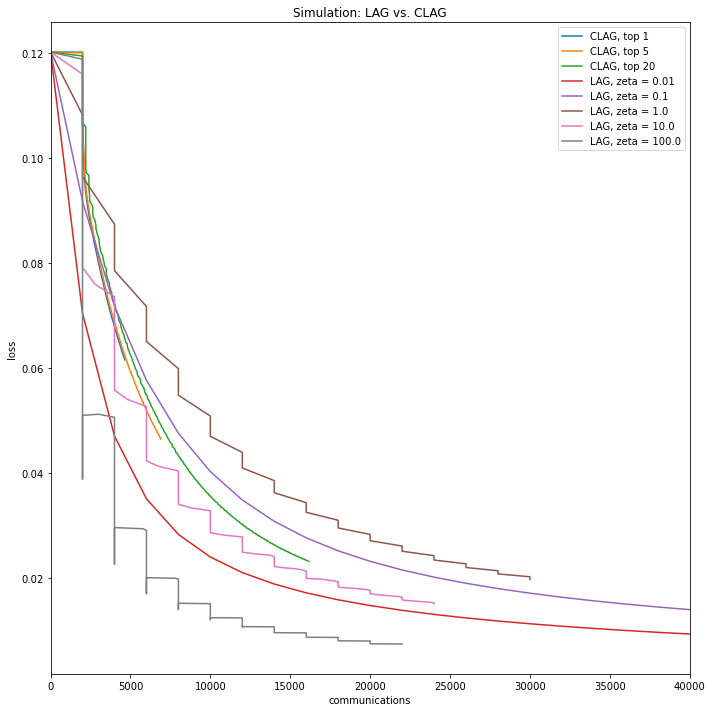

In [168]:
plt.figure(figsize=(10, 10))
for ind_k, k in enumerate(ks):
    h_CLAG, h_CLAG_comm = CLAG_histories[ind_k]
    plt.plot(h_CLAG_comm, h_CLAG, label='CLAG, top {}'.format(k))
for ind_zeta, zeta in enumerate(zetas):
    h_LAG, h_LAG_comm = LAG_histories[ind_zeta]
    plt.plot(h_LAG_comm, h_LAG, label='LAG, zeta = {}'.format(zeta))
plt.legend()
plt.xlim(left=0, right=4e4)
plt.xlabel('communications')
plt.ylabel('loss')
plt.title('Simulation: LAG vs. CLAG')
plt.tight_layout()
plt.savefig('../results/first_plot.pdf')

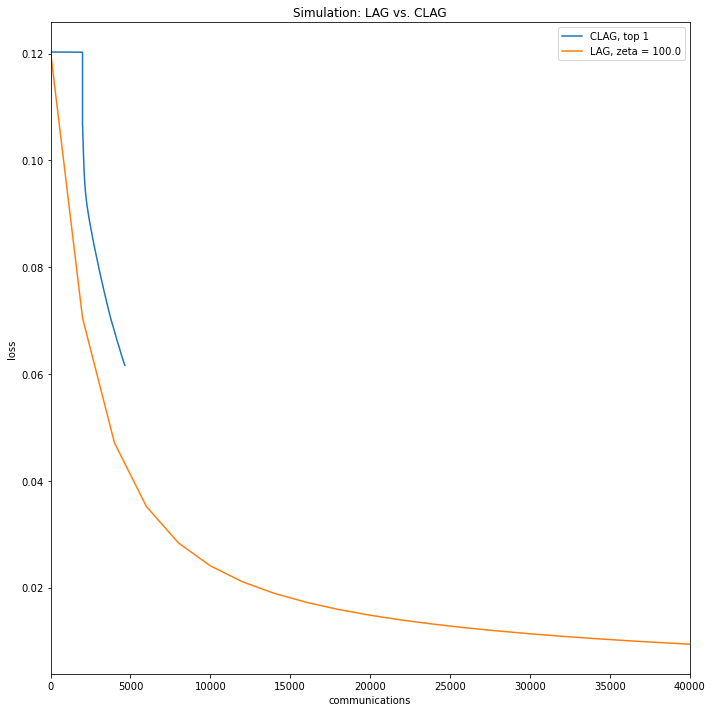

In [169]:
plt.figure(figsize=(10, 10))
for ind_k, k in enumerate([ks[0]]):
    h_CLAG, h_CLAG_comm = CLAG_histories[ind_k]
    plt.plot(h_CLAG_comm, h_CLAG, label='CLAG, top {}'.format(k))
for ind_zeta, zeta in enumerate([zetas[-1]]):
    h_LAG, h_LAG_comm = LAG_histories[ind_zeta]
    plt.plot(h_LAG_comm, h_LAG, label='LAG, zeta = {}'.format(zeta))
plt.legend()
plt.xlim(left=0, right=4e4)
plt.xlabel('communications')
plt.ylabel('loss')
plt.title('Simulation: LAG vs. CLAG')
plt.tight_layout()
plt.savefig('../results/first_plot.pdf')